# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv
df = pd.read_csv("/Users/a223053214/Downloads/Delivery_Starter/porter_data_1.csv")

df.head()


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

print(df.dtypes[['created_at', 'actual_delivery_time']])


created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol']
df[categorical_cols] = df[categorical_cols].astype('category')

print(df.dtypes[categorical_cols])

market_id                 category
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

df[['created_at', 'actual_delivery_time', 'delivery_time_minutes']].head()

created_at actual_delivery_time  delivery_time_minutes
0 2015-02-06 22:24:17  2015-02-06 23:11:17                   47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25                   44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35                   55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46                   59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36                   46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek  # 0=Monday, 6=Sunday

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].apply(lambda x: 1 if x >= 5 else 0).astype('category')

df.head()


market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  delivery_time_minutes  order_hour  \
0                      21.0     34.44                   47.0          22   
1                       2.0     27.60                   44.0          21   
2                      18.0     11.56                   55.0           0   
3                       8.0     31.80                   59.0           3   
4                       7.0      8.20                   46.0           2   

   order_dayofweek isWeekend  
0                4         0  
1                1         0  
2                0         0  
3                3         0  
4                1         0

In [7]:
# Drop unnecessary columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [8]:
# Define target variable (y) and features (X)
y = df['delivery_time_minutes']

X = df.drop('delivery_time_minutes', axis=1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (175777, 15)
y shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [9]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [10]:
# Define numerical and categorical columns for easy EDA and data manipulation
features = X_train.columns

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical Columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

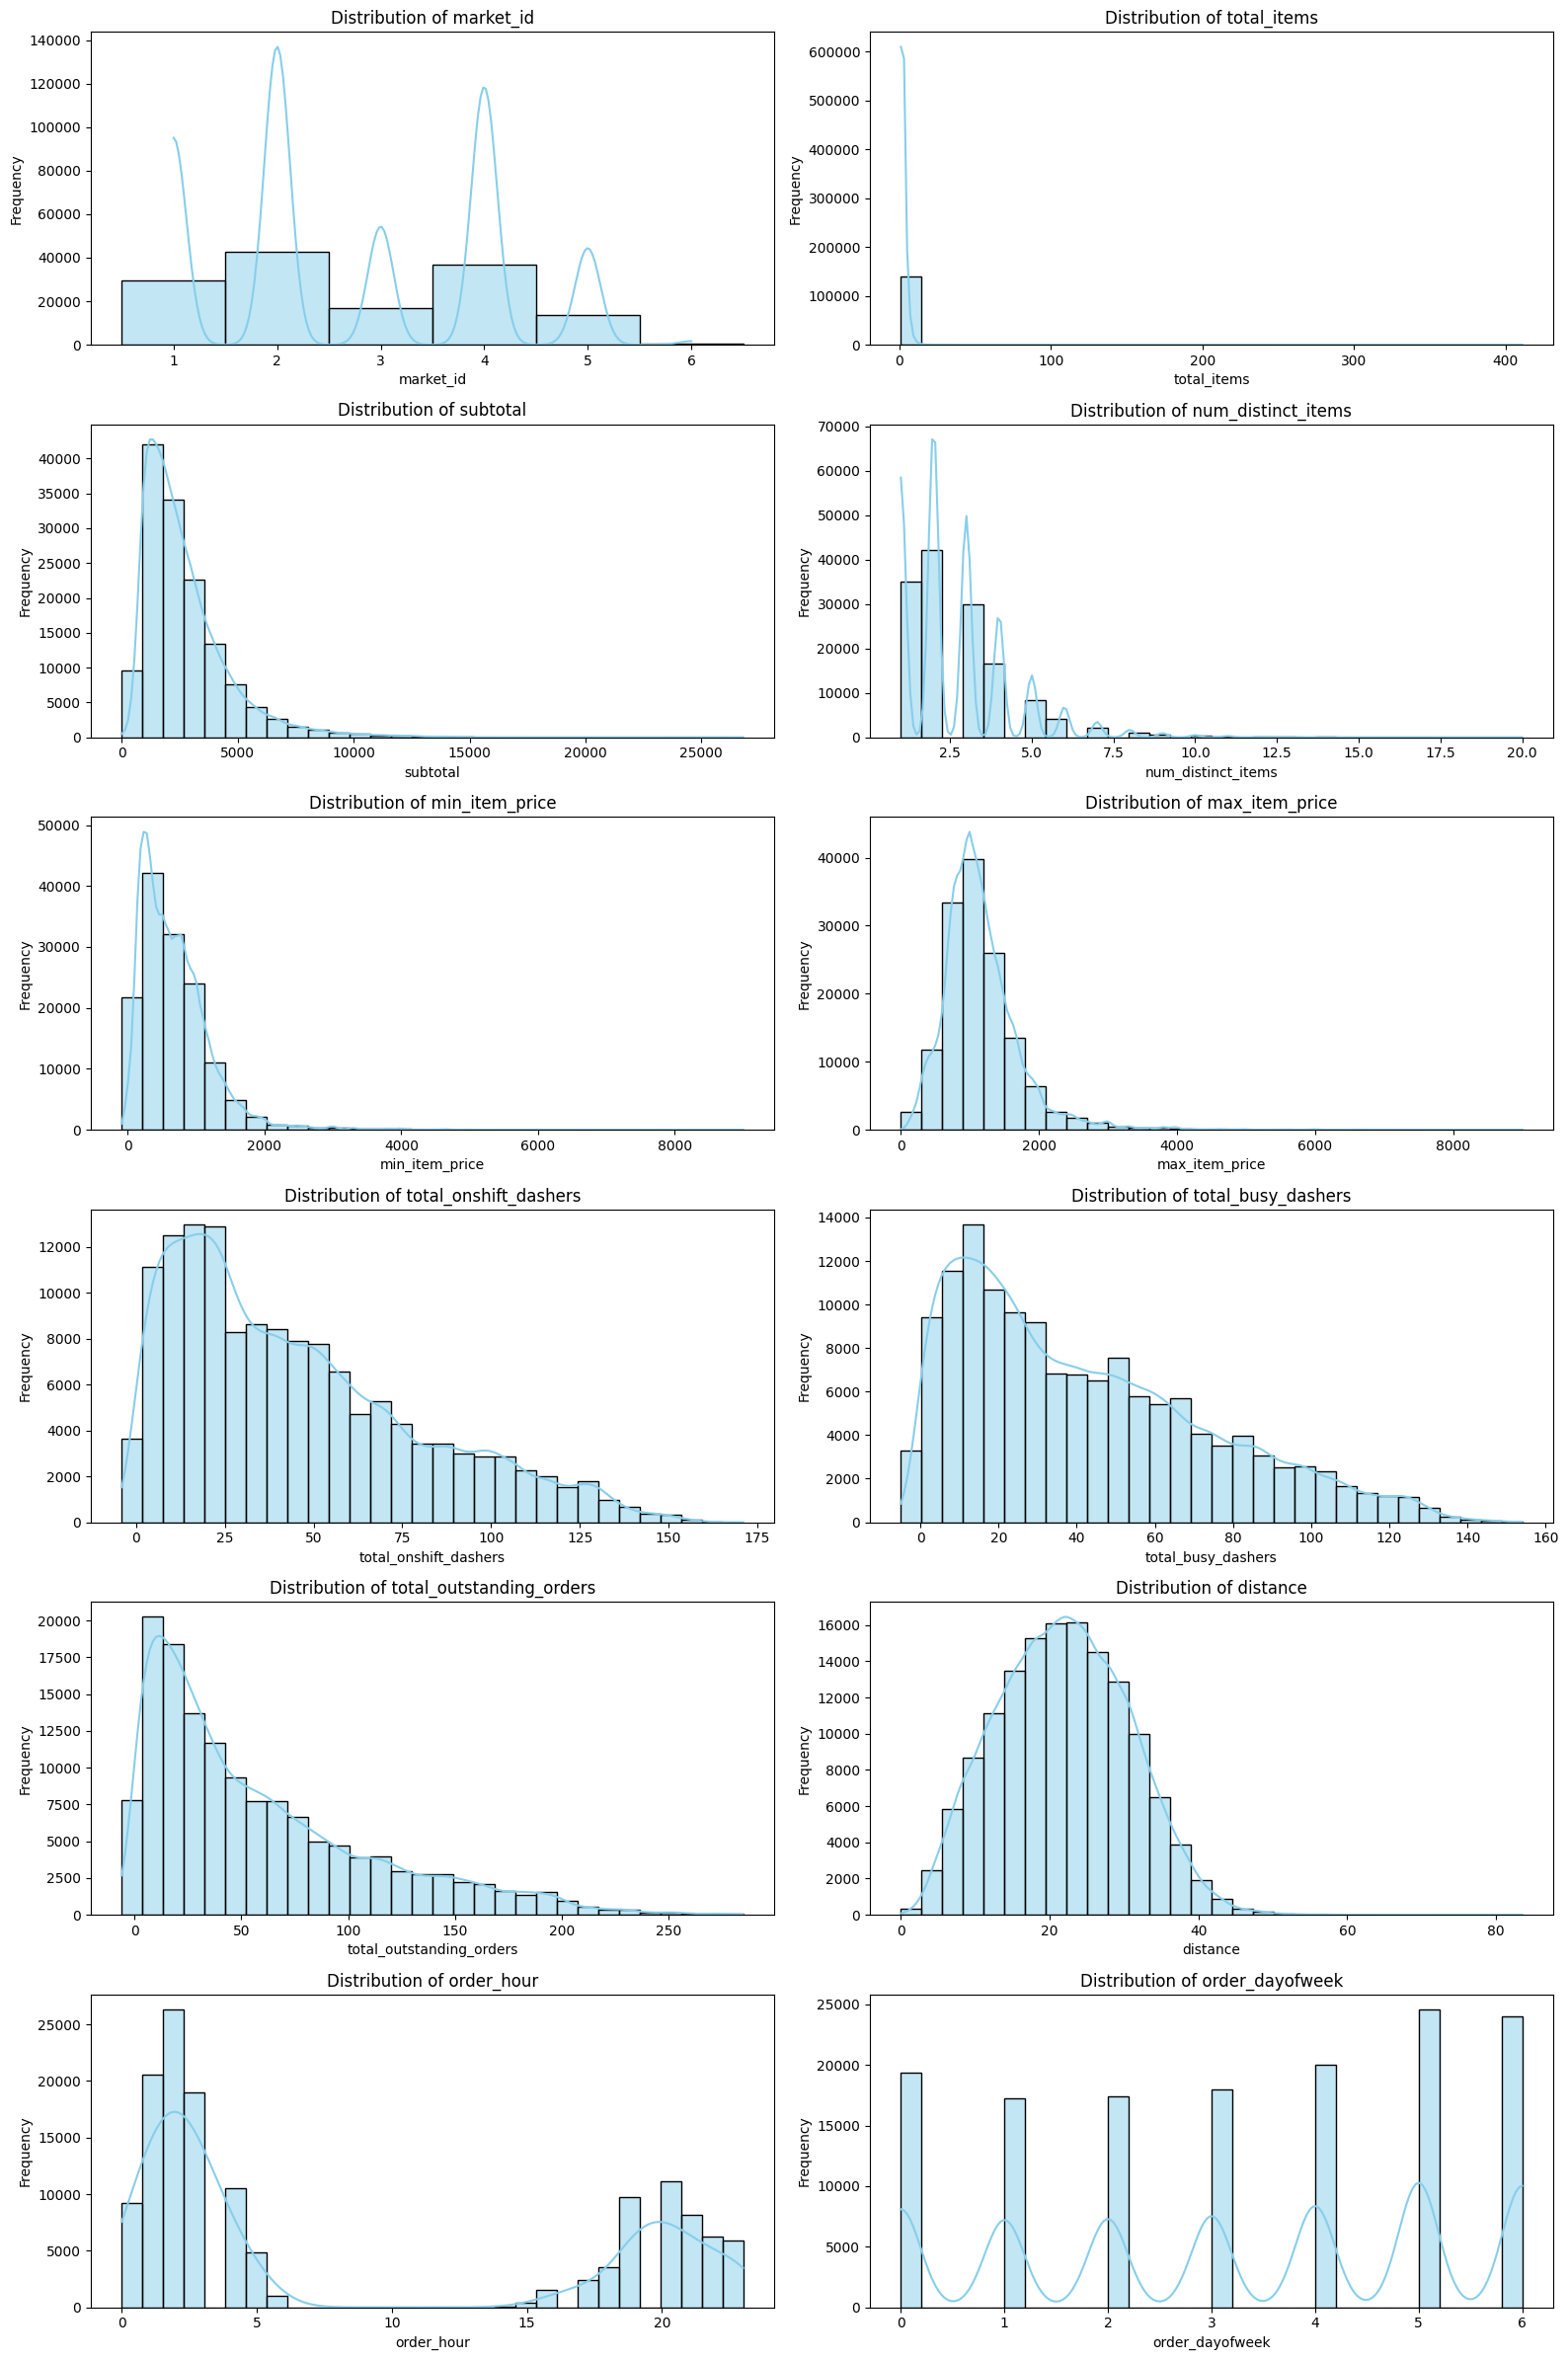

In [11]:
# Plot distributions for all numerical columns
numerical_cols = [
    'market_id',
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders',
    'distance',
    'order_hour',
    'order_dayofweek'
]

plt.figure(figsize=(16, 24))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(6, 2, i)  # 6 rows x 2 columns = 12 plots
    sns.histplot(X_train[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

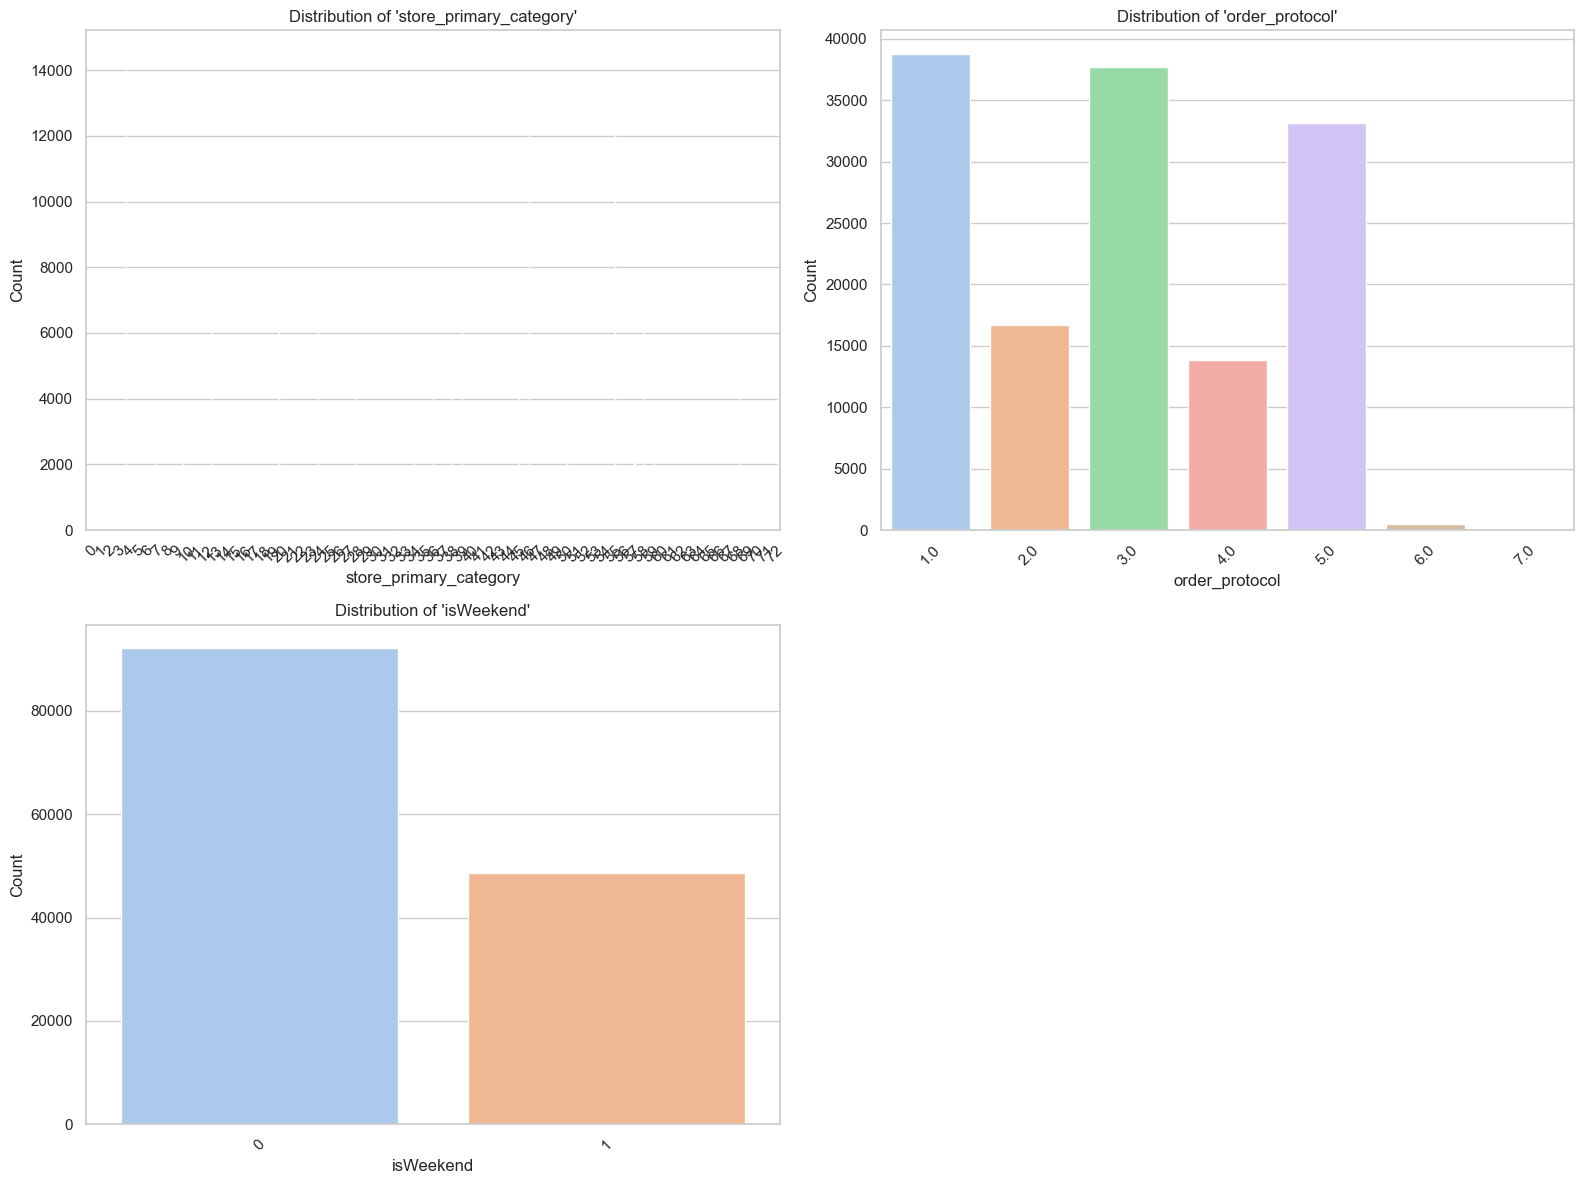

In [12]:
# Distribution of categorical columns
categorical_cols = ['store_primary_category', 'order_protocol', 'isWeekend']

sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=X_train, x=col, hue=col, palette='pastel', legend=False)
    plt.title(f"Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

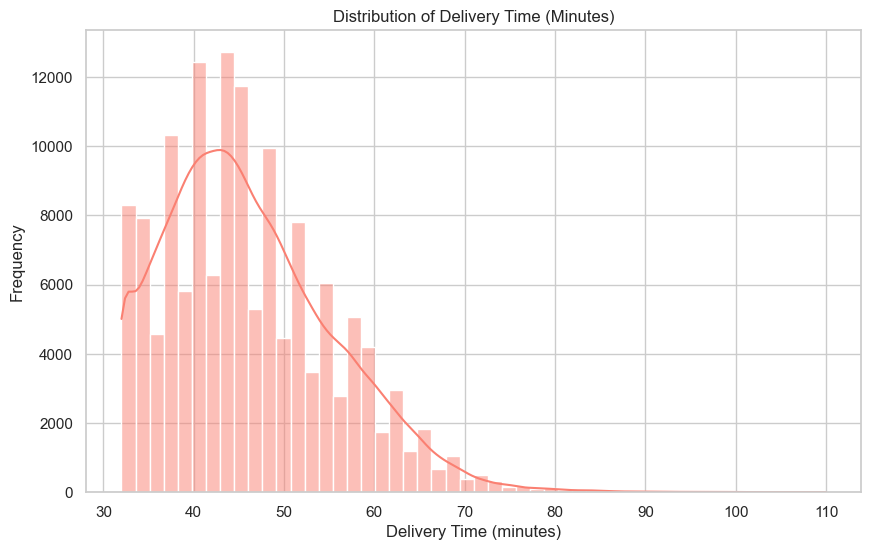

In [13]:
# Distribution of time_taken
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=50, kde=True, color='salmon')
plt.title("Distribution of Delivery Time (Minutes)")
plt.xlabel("Delivery Time (minutes)")
plt.ylabel("Frequency")
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

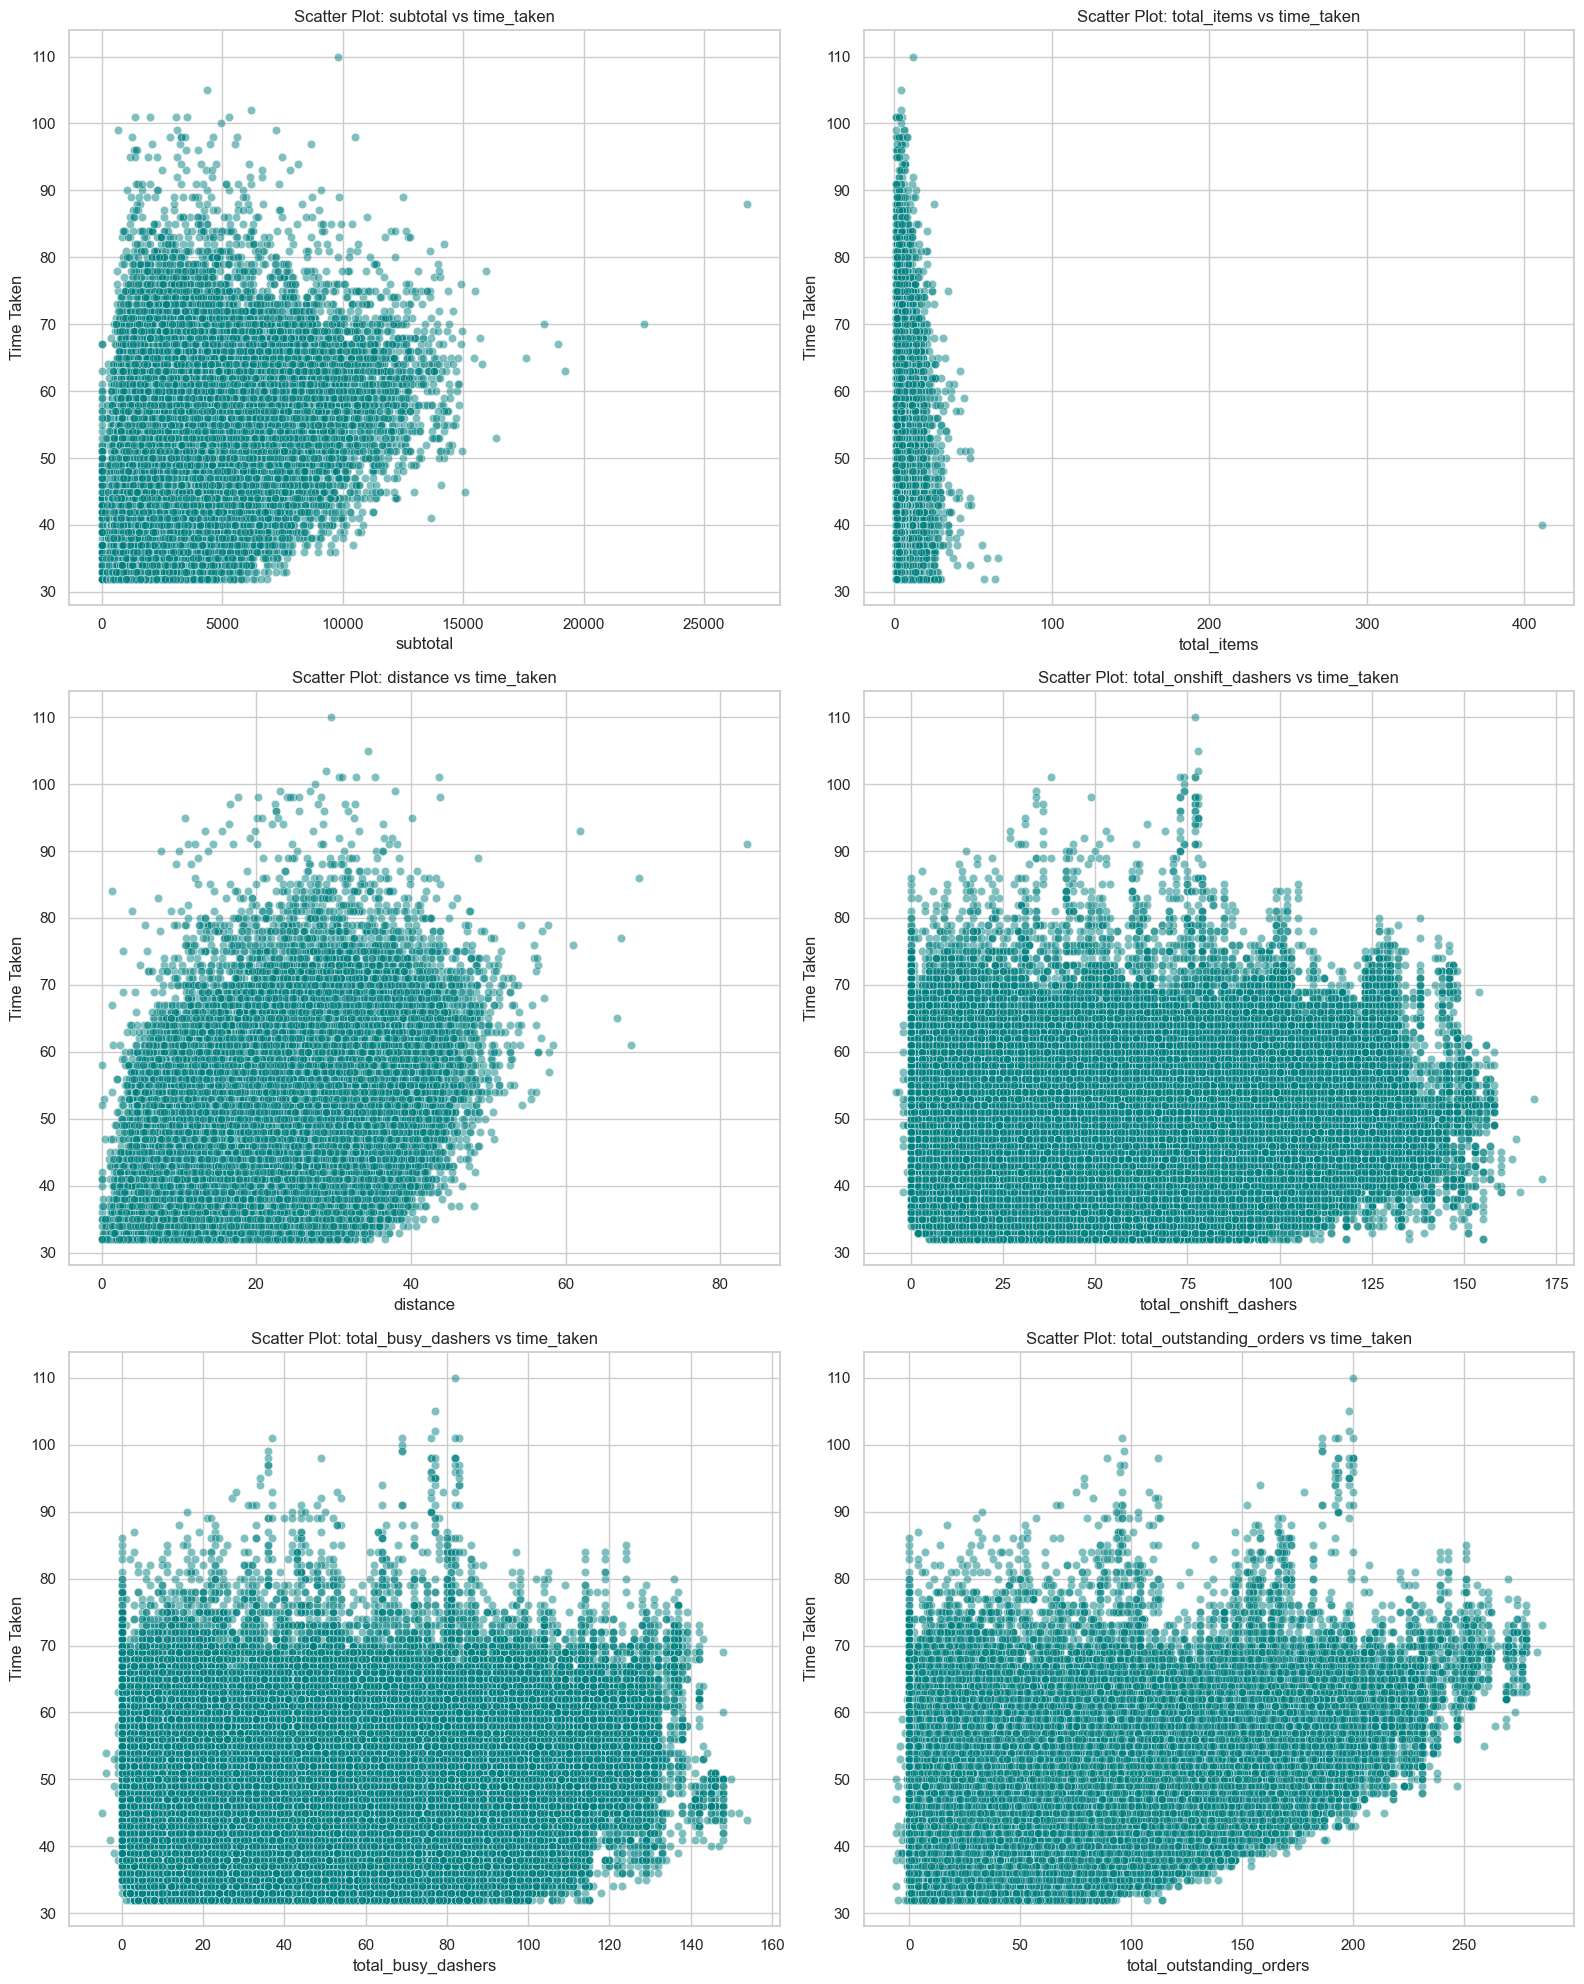

In [14]:
# Scatter plot to visualise the relationship between time_taken and other features
numerical_features = ['subtotal', 'total_items', 'distance', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']

plt.figure(figsize=(16, 20))
sns.set(style="whitegrid")

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.5, color='teal')
    plt.title(f"Scatter Plot: {feature} vs time_taken")
    plt.xlabel(feature)
    plt.ylabel("Time Taken")

plt.tight_layout()
plt.show()

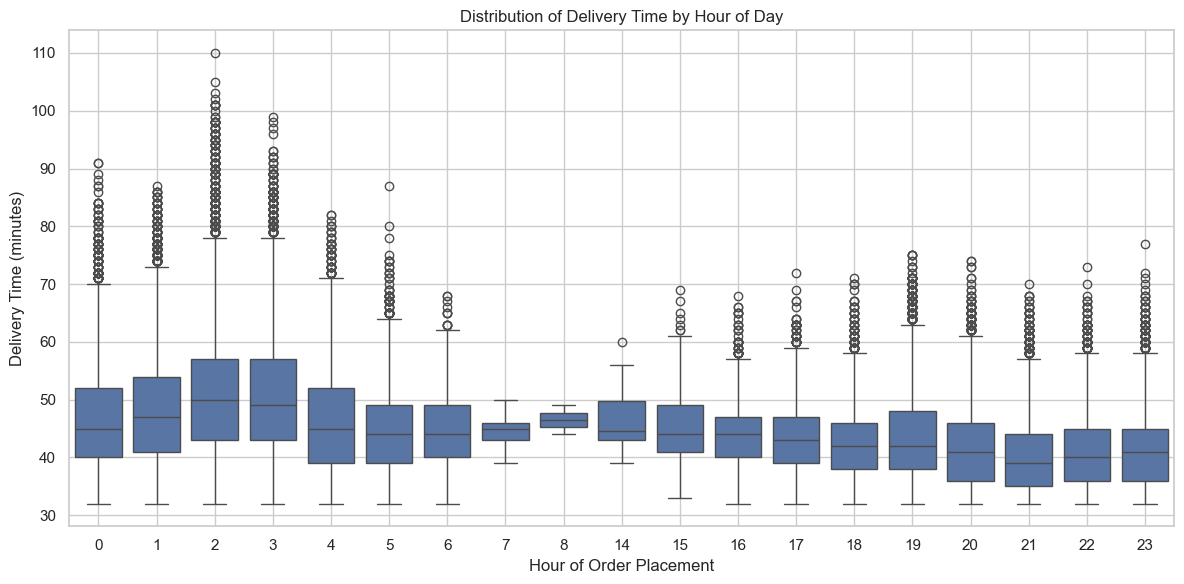

In [15]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(12, 6))
sns.boxplot(x='order_hour', y='delivery_time_minutes', data=df)

# Labels and title
plt.title('Distribution of Delivery Time by Hour of Day')
plt.xlabel('Hour of Order Placement')
plt.ylabel('Delivery Time (minutes)')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

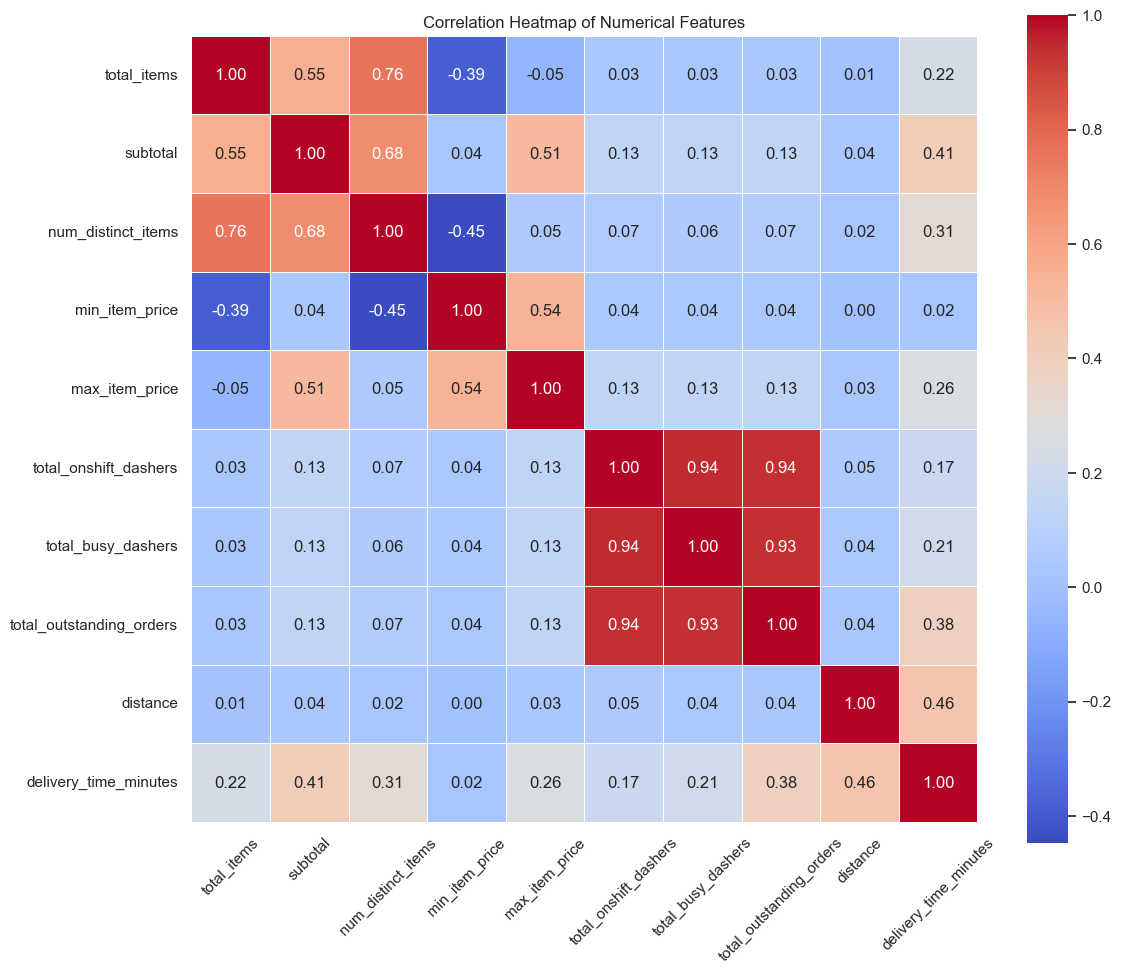

In [16]:
# Plot the heatmap of the correlation matrix

numerical_df = df.select_dtypes(include=['int64', 'float64'])

numerical_df['delivery_time_minutes'] = y

corr_matrix = numerical_df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [17]:
# Drop 3-5 weakly correlated columns from training dataset
X_with_target = X.copy()
X_with_target['delivery_time_minutes'] = y

corr_matrix = X_with_target.corr()

correlation_with_target = corr_matrix['delivery_time_minutes'].drop('delivery_time_minutes')

print("Weakest correlations with delivery_time_minutes:\n")
print(correlation_with_target.sort_values().head(5))



Weakest correlations with delivery_time_minutes:

order_hour               -0.346366
order_protocol           -0.136755
market_id                -0.073016
min_item_price            0.022753
store_primary_category    0.026973
Name: delivery_time_minutes, dtype: float64


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

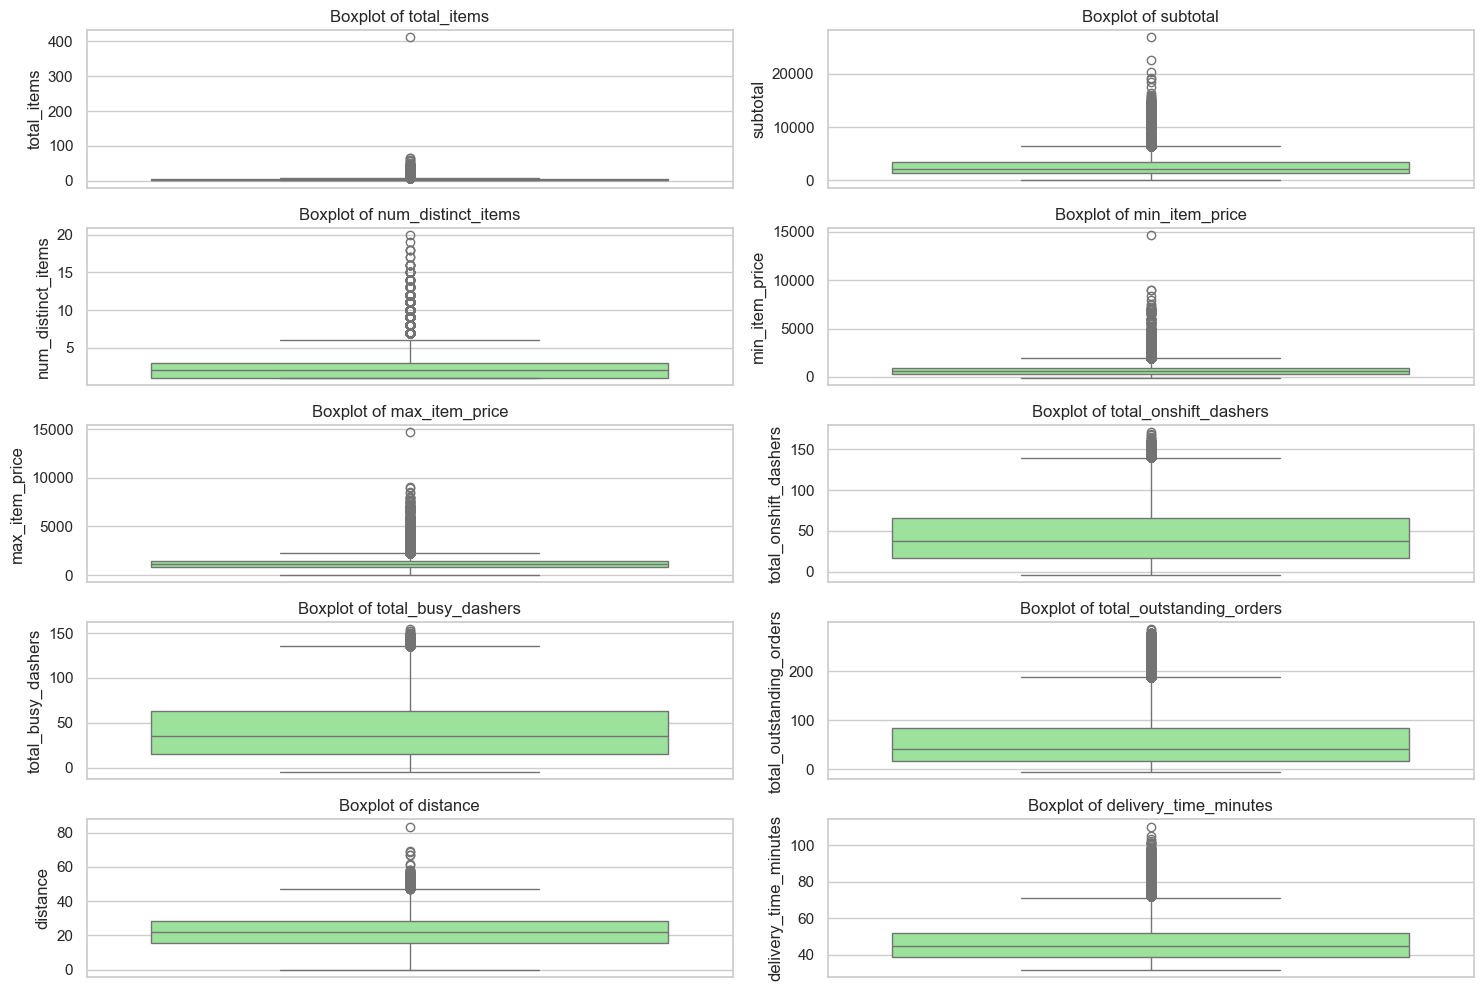

In [18]:
# Boxplot for time_taken
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_features, 1):
    plt.subplot(len(numerical_features) // 2 + 1, 2, i)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [19]:
# Handle outliers
df_trimmed = df.copy()
for col in numerical_cols:
    Q1 = df_trimmed[col].quantile(0.25)
    Q3 = df_trimmed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_trimmed = df_trimmed[(df_trimmed[col] >= lower_bound) & (df_trimmed[col] <= upper_bound)]

print("Original rows:", df.shape[0])
print("After removing outliers:", df_trimmed.shape[0])
print("Rows removed:", df.shape[0] - df_trimmed.shape[0])

AssertionError: 

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


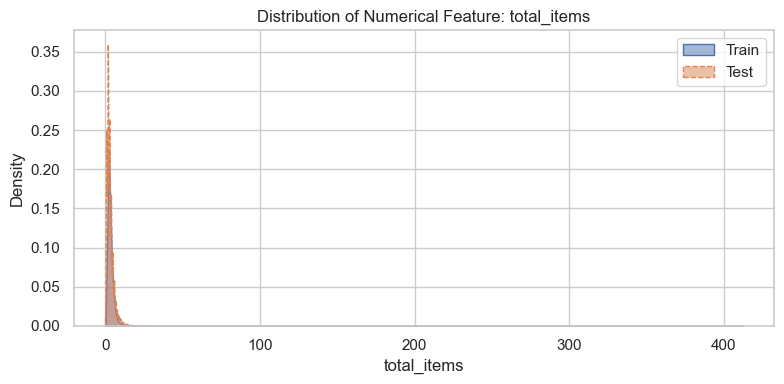

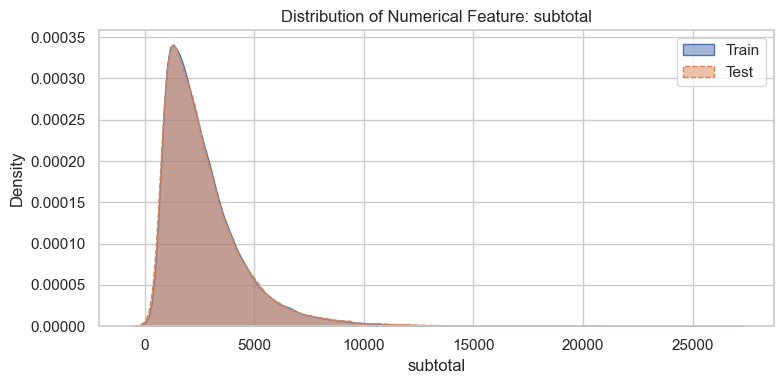

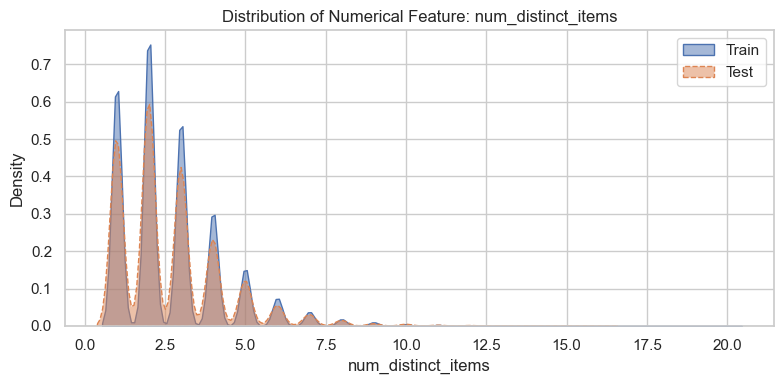

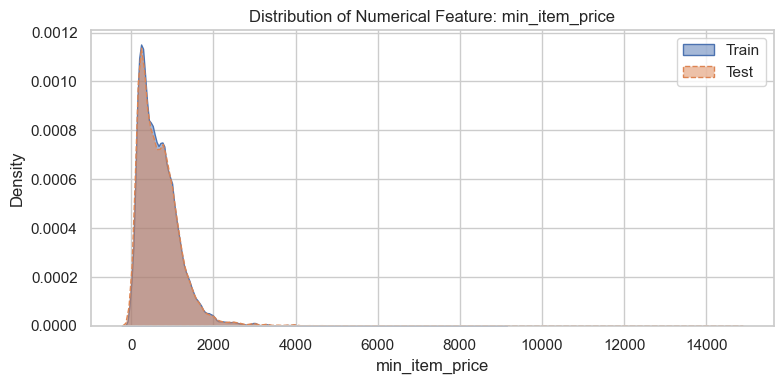

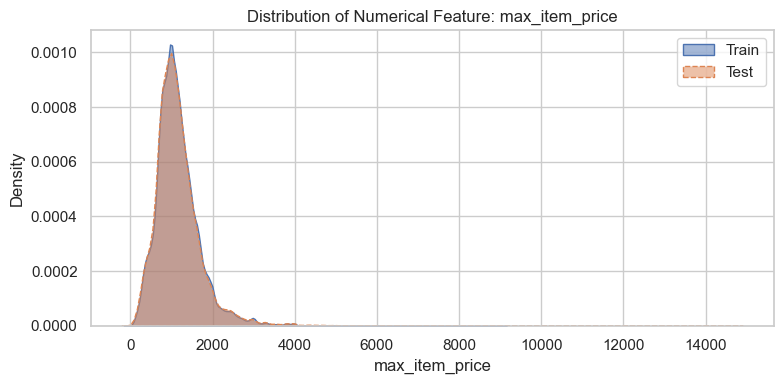

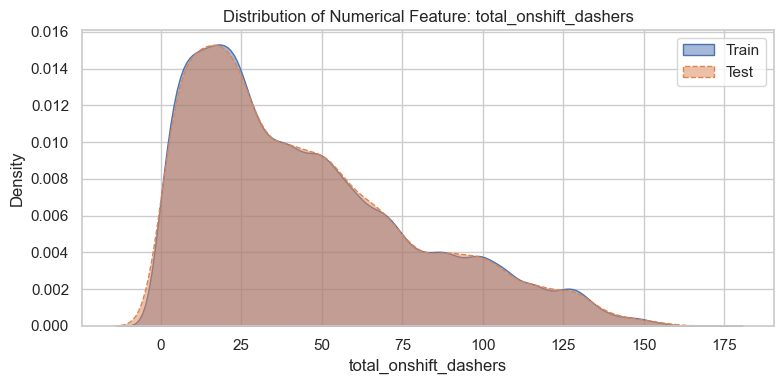

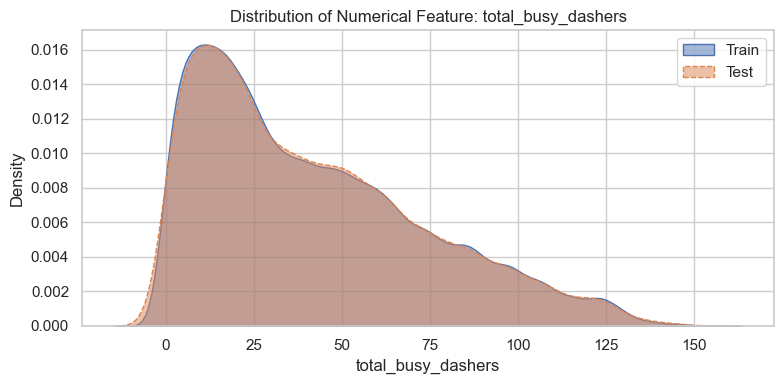

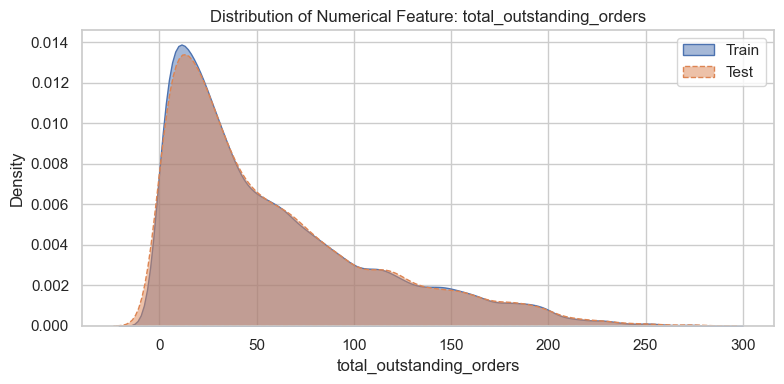

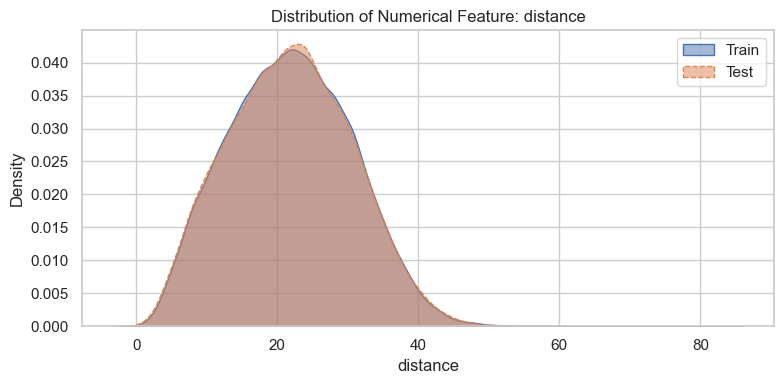

<Figure size 800x400 with 0 Axes>

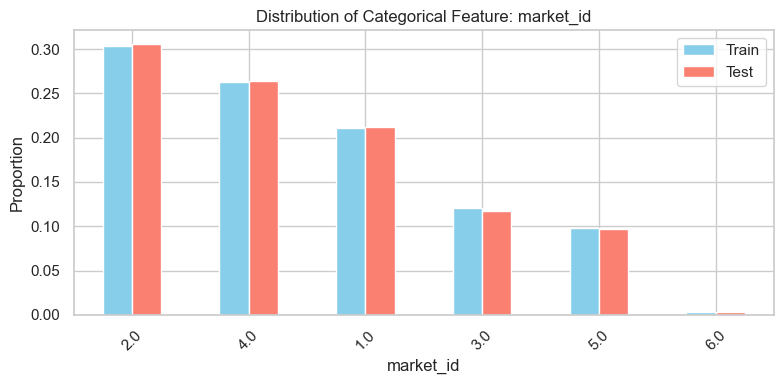

<Figure size 800x400 with 0 Axes>

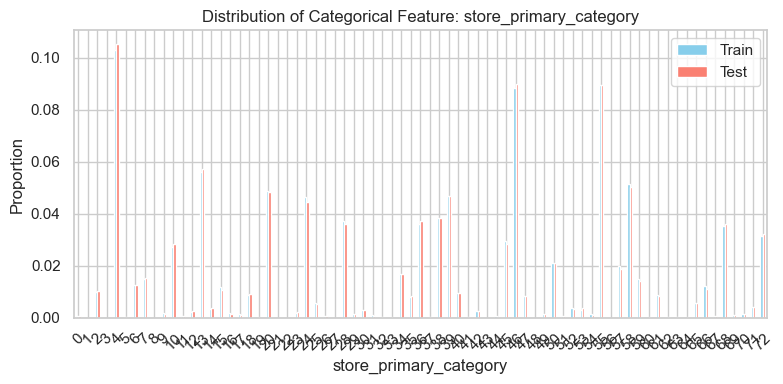

<Figure size 800x400 with 0 Axes>

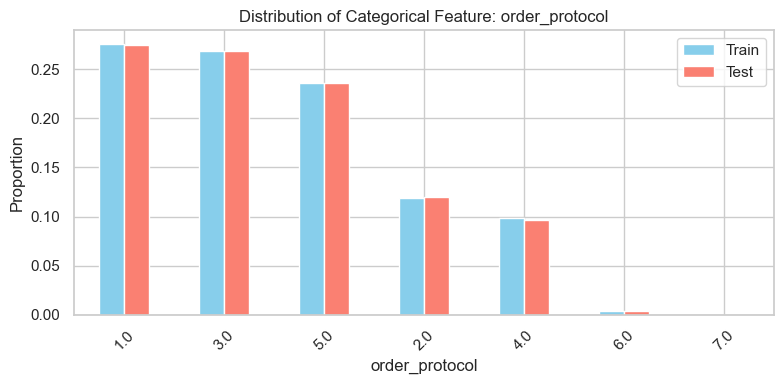

<Figure size 800x400 with 0 Axes>

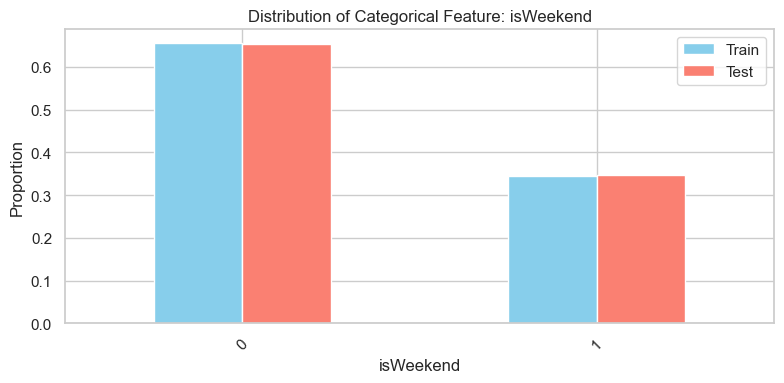

In [20]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include='category').columns

print("Numerical columns:", list(numerical_cols))
print("Categorical columns:", list(categorical_cols))


for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train[col], label='Train', fill=True, alpha=0.5)
    sns.kdeplot(X_test[col], label='Test', fill=True, alpha=0.5, linestyle='--')
    plt.title(f'Distribution of Numerical Feature: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    train_counts = X_train[col].value_counts(normalize=True)
    test_counts = X_test[col].value_counts(normalize=True)

    comparison_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)

    comparison_df.plot(kind='bar', figsize=(8, 4), color=['skyblue', 'salmon'])
    plt.title(f'Distribution of Categorical Feature: {col}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

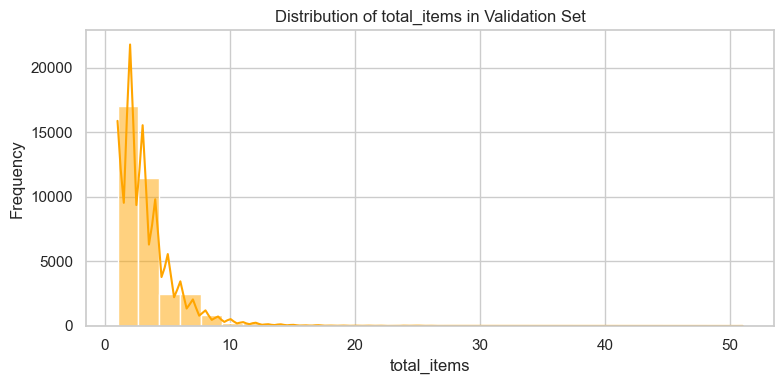

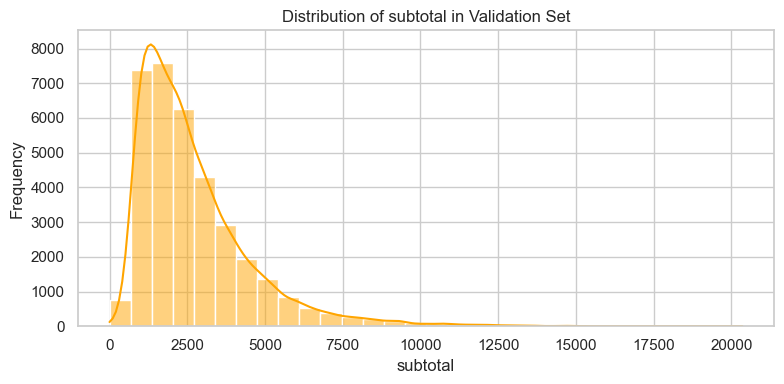

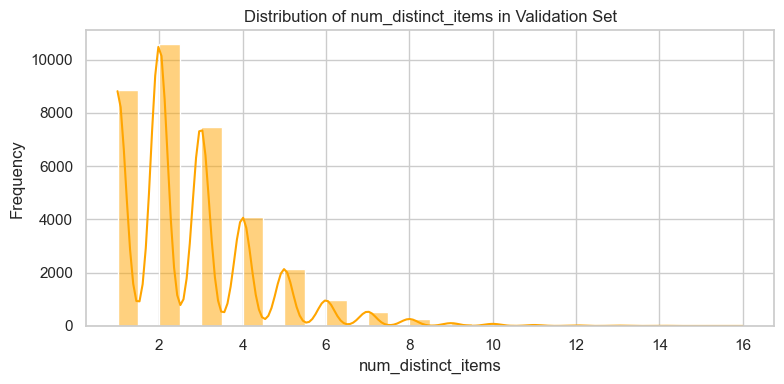

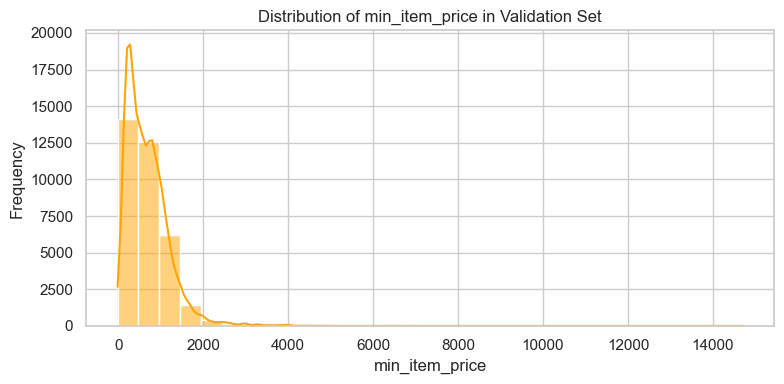

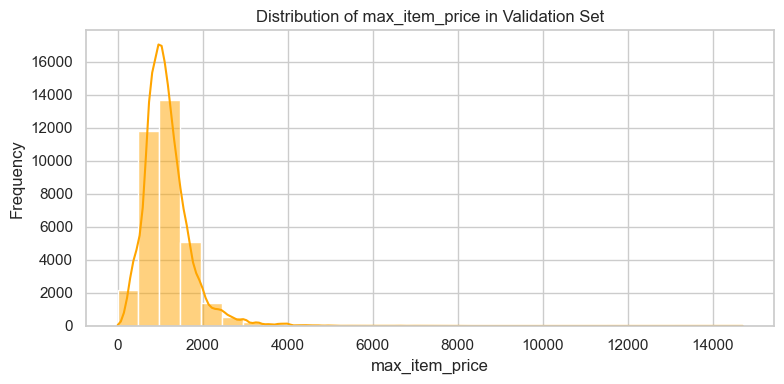

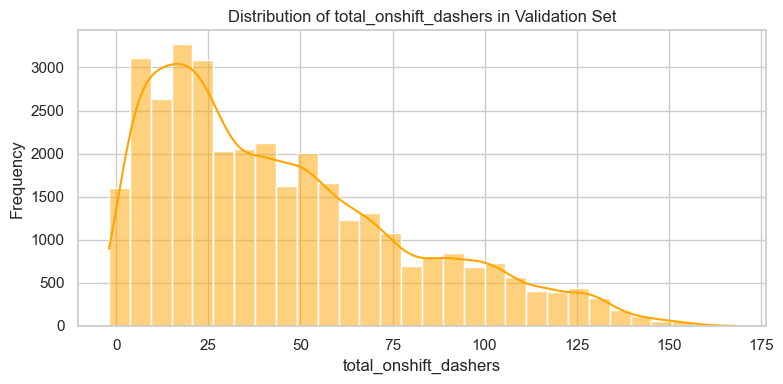

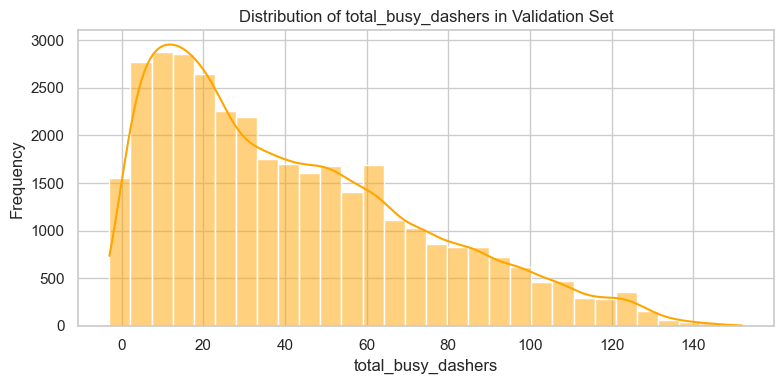

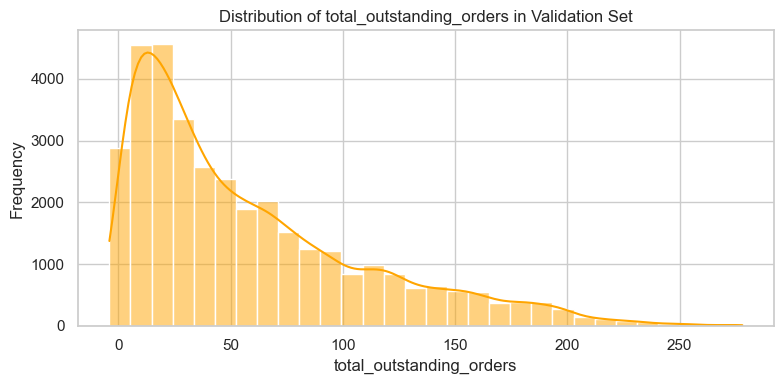

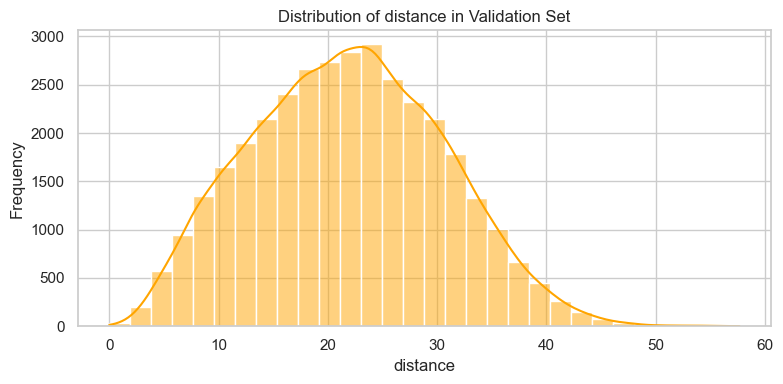

In [21]:
# Plot distributions for all numerical columns
numerical_cols = X_test.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_test[col], kde=True, bins=30, color='orange')
    plt.title(f'Distribution of {col} in Validation Set')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

##### **4.1.2**
Check the distribution of categorical features

Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


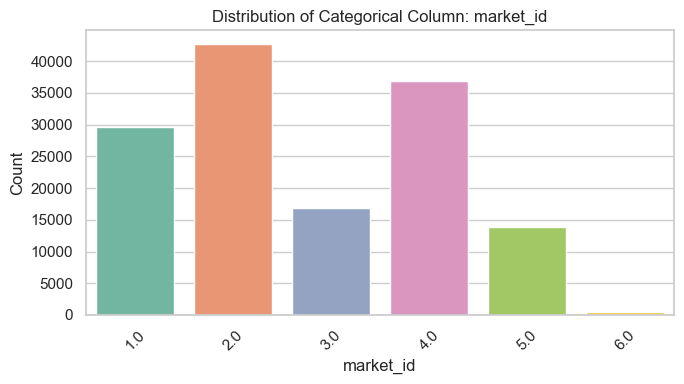

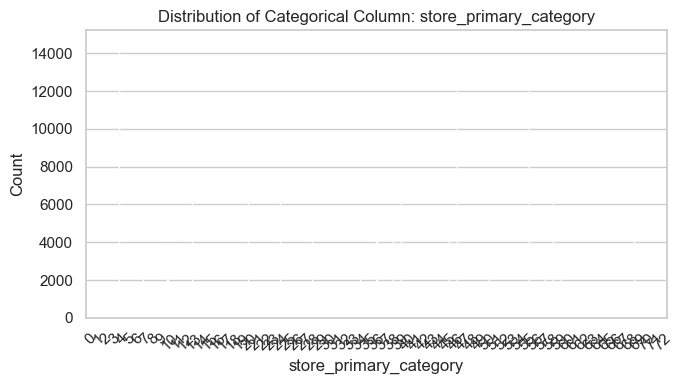

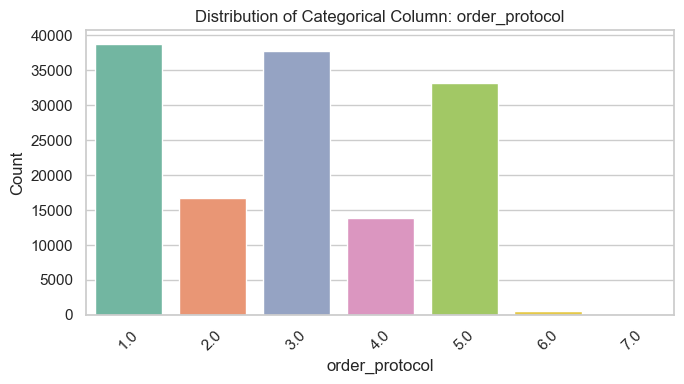

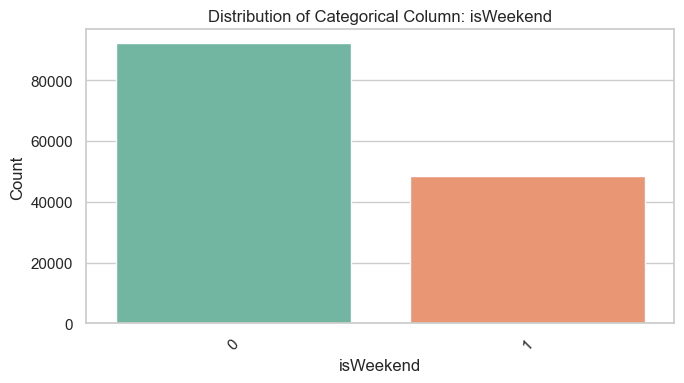

In [22]:
# Distribution of categorical columns
categorical_cols = X_train.select_dtypes(include='category').columns
print("Categorical columns:", list(categorical_cols))

for col in categorical_cols:
    plt.figure(figsize=(7, 4))
    sns.countplot(data=X_train, x=col, hue=col, palette='Set2', legend=False)
    plt.title(f'Distribution of Categorical Column: {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

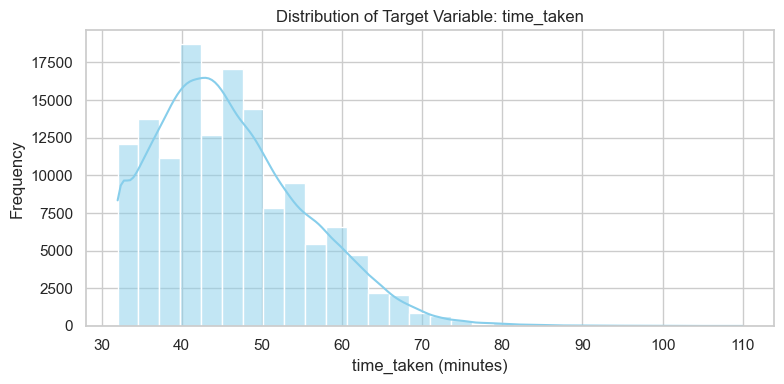

In [23]:
# Distribution of time_taken
plt.figure(figsize=(8, 4))
sns.histplot(y_train, bins=30, kde=True, color='skyblue')
plt.title("Distribution of Target Variable: time_taken")
plt.xlabel("time_taken (minutes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

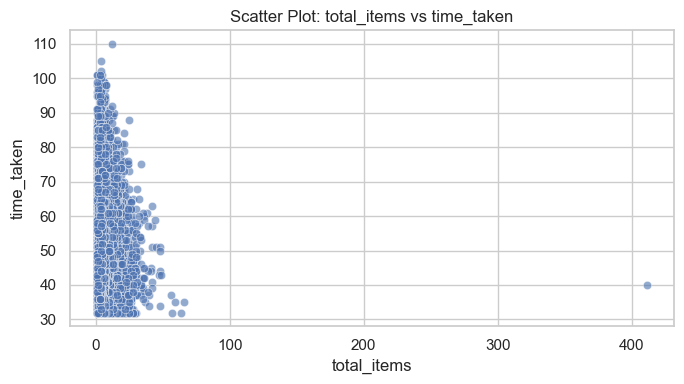

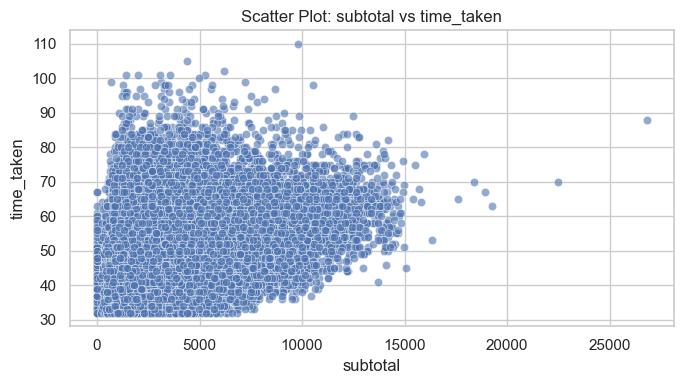

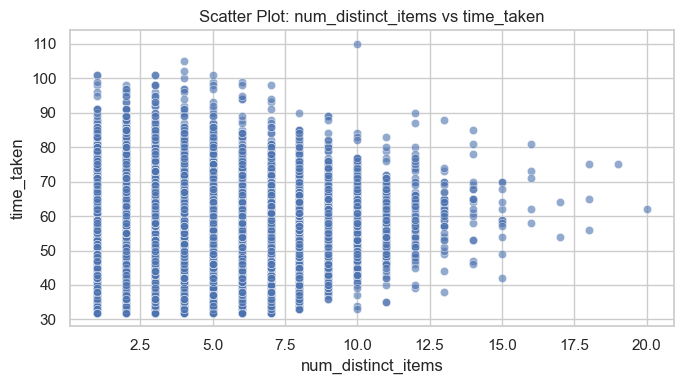

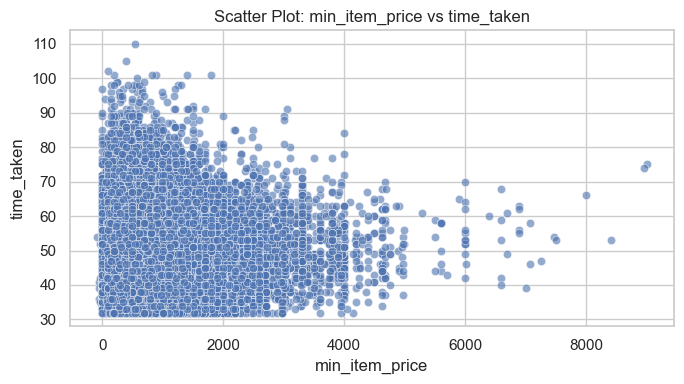

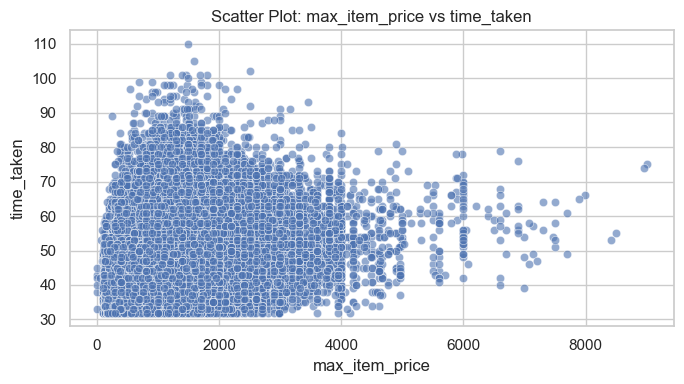

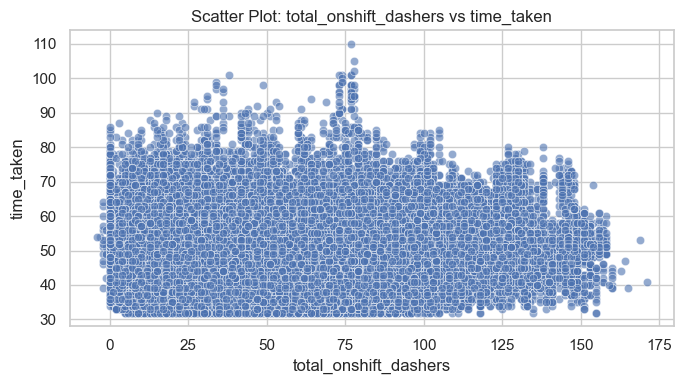

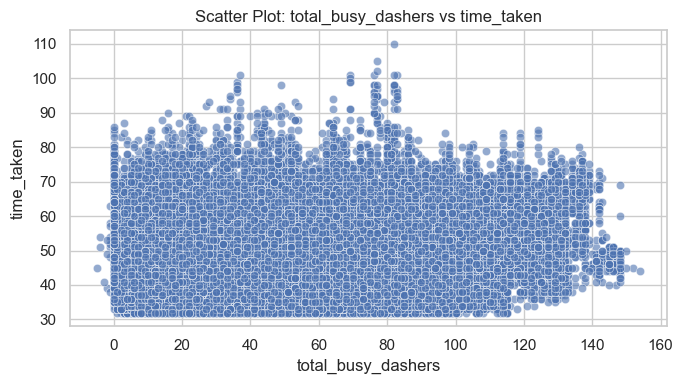

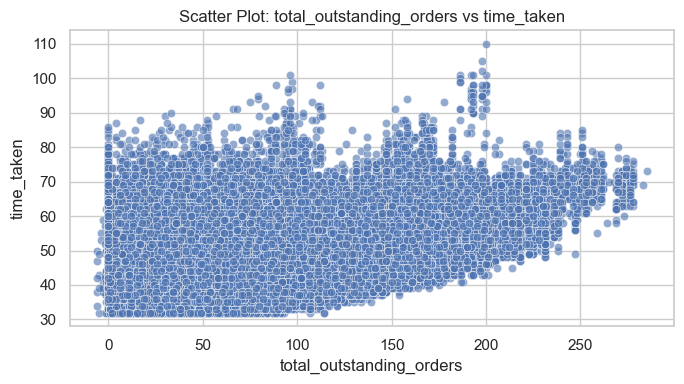

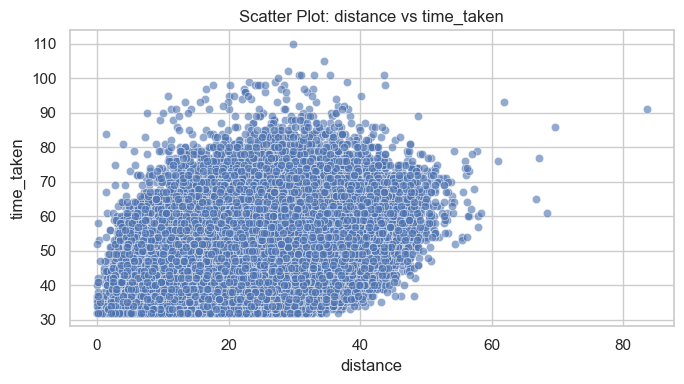

In [24]:
# Scatter plot to visualise the relationship between time_taken and other features
df_scatter = X_train.copy()
df_scatter['time_taken'] = y_train

numerical_cols = df_scatter.select_dtypes(include=['int64', 'float64']).columns.drop('time_taken')

for col in numerical_cols:
    plt.figure(figsize=(7, 4))
    sns.scatterplot(data=df_scatter, x=col, y='time_taken', alpha=0.6)
    plt.title(f'Scatter Plot: {col} vs time_taken')
    plt.xlabel(col)
    plt.ylabel('time_taken')
    plt.tight_layout()
    plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [25]:
# Drop the weakly correlated columns from training dataset
train_df = X_train.copy()
train_df['time_taken'] = y_train

corr_matrix = train_df.corr(numeric_only=True)

correlations = corr_matrix['time_taken'].drop('time_taken')
print("Correlation of features with time_taken:\n")
print(correlations)

threshold = 0.05
weak_corr_features = correlations[correlations.abs() < threshold].index.tolist()

print("\nWeakly correlated features to drop:", weak_corr_features)

X_train.drop(columns=weak_corr_features, inplace=True)
X_test.drop(columns=weak_corr_features, inplace=True)


Correlation of features with time_taken:

total_items                 0.220804
subtotal                    0.413392
num_distinct_items          0.312510
min_item_price              0.021151
max_item_price              0.254650
total_onshift_dashers       0.171828
total_busy_dashers          0.206514
total_outstanding_orders    0.385028
distance                    0.461026
order_hour                 -0.345716
order_dayofweek             0.044897
Name: time_taken, dtype: float64

Weakly correlated features to drop: ['min_item_price', 'order_dayofweek']


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [26]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV, train_test_split


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

Numerical columns to be scaled: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']

Mean after scaling:
 total_items                -4.759824e-17
subtotal                    4.567814e-17
num_distinct_items         -4.668872e-17
max_item_price              2.571922e-17
total_onshift_dashers       2.324330e-17
total_busy_dashers         -8.488859e-17
total_outstanding_orders   -2.117162e-17
distance                    1.580545e-16
dtype: float64

Standard deviation after scaling:
 total_items                 1.000004
subtotal                    1.000004
num_distinct_items          1.000004
max_item_price              1.000004
total_onshift_dashers       1.000004
total_busy_dashers          1.000004
total_outstanding_orders    1.000004
distance                    1.000004
dtype: float64


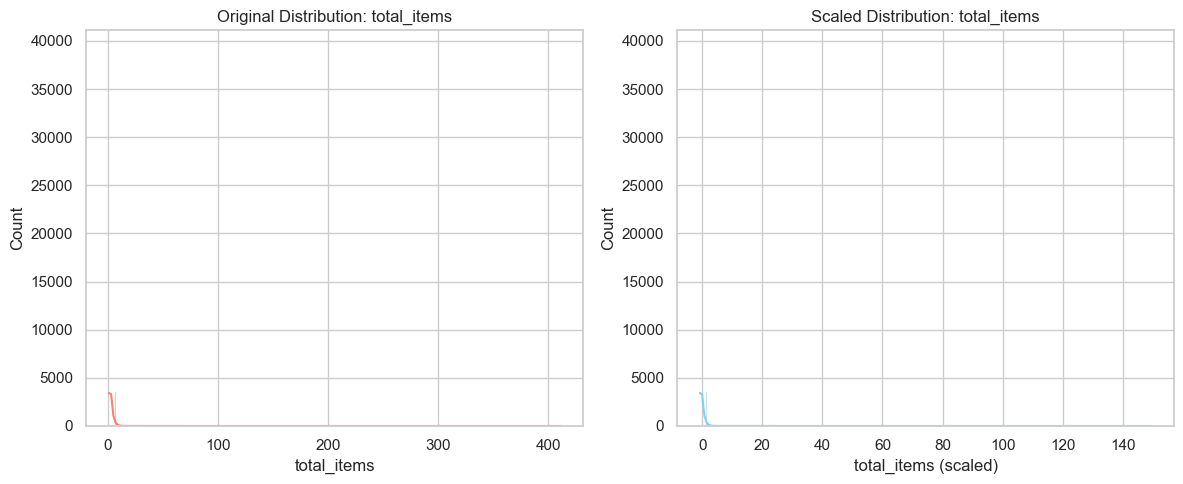

In [27]:
# Apply scaling to the numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns to be scaled:", list(numerical_cols))

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

X_test_scaled = X_test.copy()
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("\nMean after scaling:\n", X_train_scaled[numerical_cols].mean())
print("\nStandard deviation after scaling:\n", X_train_scaled[numerical_cols].std())


feature = numerical_cols[0] 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(X_train[feature], kde=True, color='salmon')
plt.title(f'Original Distribution: {feature}')
plt.xlabel(feature)

plt.subplot(1, 2, 2)
sns.histplot(X_train_scaled[feature], kde=True, color='skyblue')
plt.title(f'Scaled Distribution: {feature}')
plt.xlabel(f'{feature} (scaled)')

plt.tight_layout()
plt.show()


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [28]:
# Create/Initialise the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Linear Regression Model Performance:
R² Score: 0.8809
Mean Absolute Error (MAE): 2.33
Root Mean Squared Error (RMSE): 3.23


In [29]:
# Train the model using the training data
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

print("Linear Regression model trained successfully.")


Linear Regression model trained successfully.


In [30]:
# Make predictions
y_pred = lr_model.predict(X_test_scaled)

print("Predicted values (first 10):", y_pred[:10])


Predicted values (first 10): [50.99056714 65.85074984 41.1457559  42.42242318 40.12605648 27.26109306
 36.32547947 43.20360256 32.04410571 47.76217818]


In [31]:
# Find results for evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluation Metrics for Linear Regression:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")



Evaluation Metrics for Linear Regression:
R² Score: 0.8809
Mean Absolute Error (MAE): 2.33 minutes
Root Mean Squared Error (RMSE): 3.23 minutes


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

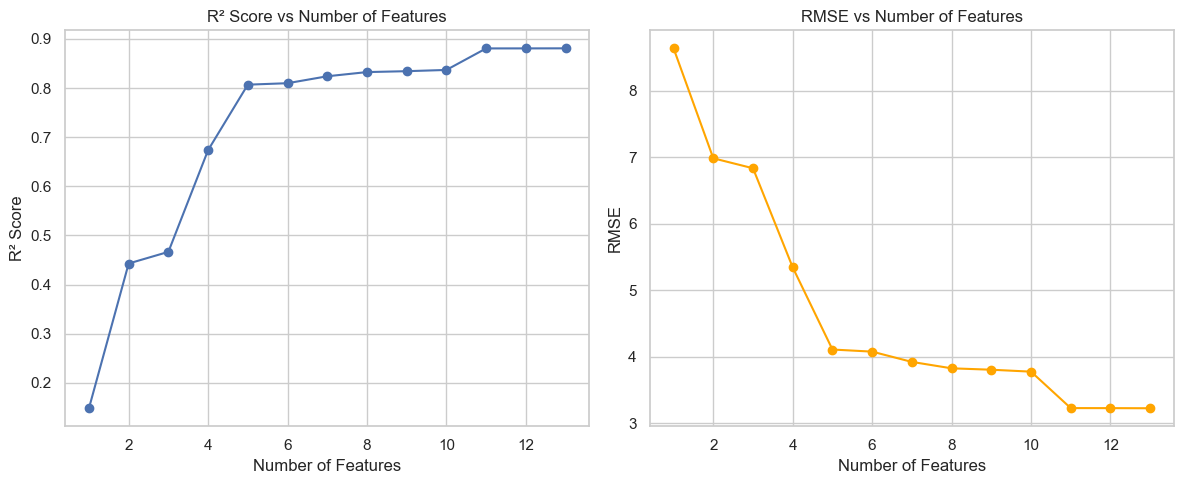


 Best number of features: 13
   R² Score: 0.8809
   RMSE: 3.23


In [32]:
# Loop through the number of features and test the model
r2_scores = []
rmse_scores = []
num_features_list = list(range(1, X_train_scaled.shape[1] + 1))

for n in num_features_list:
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_rfe, y_train)
    
    y_pred = model.predict(X_test_rfe)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_features_list, r2_scores, marker='o')
plt.title('R² Score vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')

plt.subplot(1, 2, 2)
plt.plot(num_features_list, rmse_scores, marker='o', color='orange')
plt.title('RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

best_index = np.argmax(r2_scores)
print(f"\n Best number of features: {num_features_list[best_index]}")
print(f"   R² Score: {r2_scores[best_index]:.4f}")
print(f"   RMSE: {rmse_scores[best_index]:.2f}")

In [33]:
# Build the final model with selected number of features
best_n = num_features_list[best_index]

final_rfe = RFE(estimator=LinearRegression(), n_features_to_select=best_n)
X_train_rfe_final = final_rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe_final = final_rfe.transform(X_test_scaled)

selected_features = X_train_scaled.columns[final_rfe.support_]
print(f"\nSelected features for final model:\n{list(selected_features)}")

final_model = LinearRegression()
final_model.fit(X_train_rfe_final, y_train)

y_pred_final = final_model.predict(X_test_rfe_final)

r2 = r2_score(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
mae = mean_absolute_error(y_test, y_pred_final)

print("\nFinal Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")



Selected features for final model:
['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']

Final Model Performance:
R² Score: 0.8809
RMSE: 3.23
MAE: 2.33


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

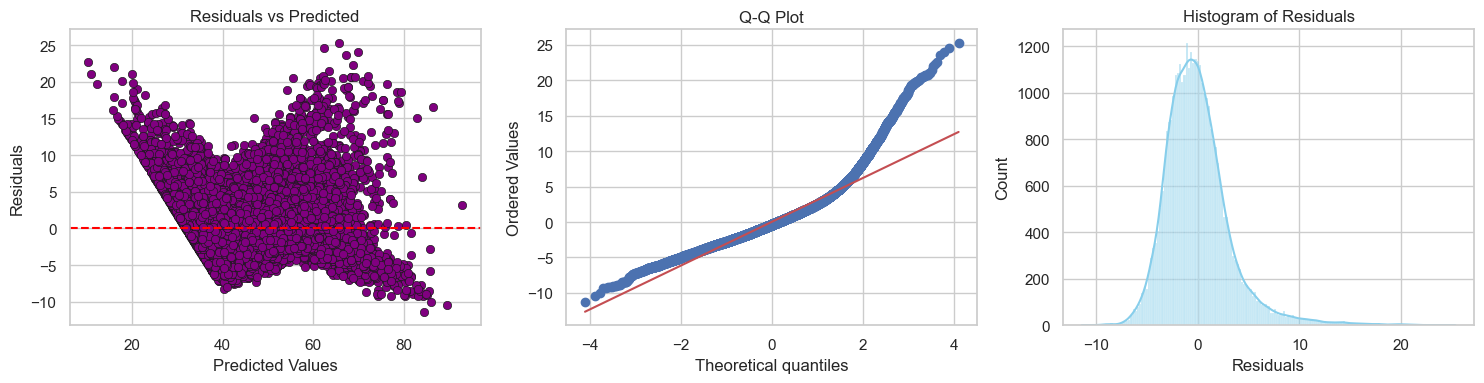

In [34]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
from scipy import stats
residuals = y_test - y_pred_final

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred_final, y=residuals, color='purple', edgecolor='k')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")

plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")

plt.subplot(1, 3, 3)
sns.histplot(residuals, kde=True, color='skyblue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")

plt.tight_layout()
plt.show()


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [36]:
# Compare the scaled vs unscaled features used in the final model
selected_features = list(selected_features)

# Extract scaled coefficients from the final model
scaled_coefs = final_model.coef_

numeric_features = [col for col in selected_features if col in scaler.feature_names_in_]
categorical_features = [col for col in selected_features if col not in numeric_features]

scaler_feature_names = list(scaler.feature_names_in_)
scaler_scales_map = dict(zip(scaler_feature_names, scaler.scale_))

numeric_indices = [selected_features.index(f) for f in numeric_features]
scaler_scales = np.array([scaler_scales_map[f] for f in numeric_features])
numeric_scaled_coefs = scaled_coefs[numeric_indices]
numeric_unscaled_coefs = numeric_scaled_coefs / scaler_scales

numeric_df = pd.DataFrame({
    'Feature': numeric_features,
    'Coefficient (scaled)': numeric_scaled_coefs,
    'Coefficient (unscaled)': numeric_unscaled_coefs
})

categorical_indices = [selected_features.index(f) for f in categorical_features]
categorical_scaled_coefs = scaled_coefs[categorical_indices]

categorical_df = pd.DataFrame({
    'Feature': categorical_features,
    'Coefficient (scaled)': categorical_scaled_coefs,
    'Coefficient (unscaled)': ['N/A'] * len(categorical_features)
})

coef_df = pd.concat([numeric_df, categorical_df], ignore_index=True)
coef_df = coef_df.sort_values(by='Coefficient (scaled)', key=lambda x: abs(pd.to_numeric(x, errors='coerce')), ascending=False)

print("\n Coefficient Comparison (Scaled vs Unscaled):\n")
print(coef_df)



 Coefficient Comparison (Scaled vs Unscaled):

                     Feature  Coefficient (scaled) Coefficient (unscaled)
6   total_outstanding_orders             18.320533               0.347154
4      total_onshift_dashers            -12.523425              -0.362238
5         total_busy_dashers             -4.544503              -0.141144
7                   distance              4.168544               0.476344
1                   subtotal              2.307014                0.00126
12                 isWeekend              1.216431                    N/A
2         num_distinct_items              0.867375               0.533435
10            order_protocol             -0.678033                    N/A
8                  market_id             -0.620637                    N/A
3             max_item_price              0.365198               0.000652
11                order_hour             -0.248633                    N/A
0                total_items             -0.111781              

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [37]:
# Analyze the effect of a unit change in a feature, say 'total_items'
effect_row = coef_df[coef_df['Feature'] == 'total_items']

if not effect_row.empty and effect_row.iloc[0]['Coefficient (unscaled)'] != 'N/A':
    effect = effect_row.iloc[0]['Coefficient (unscaled)']
    print(f" A 1-unit increase in 'total_items' is associated with a change of approximately {effect:.2f} minutes in delivery time.")
else:
    print("'total_items' is a categorical variable or was not used in the model. Cannot compute unscaled effect.")


 A 1-unit increase in 'total_items' is associated with a change of approximately -0.04 minutes in delivery time.


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>The dataset contains categorical variables, with the most relevant being Type_of_order, Type_of_vehicle, and Festival. These variables were encoded and transformed effectively for the analysis, benefiting the model.

From the analysis and selection process, certain categorical fields, such as Type_of_order and Festival, remained in the final model, indicating that they do not directly impact delivery time. However, the presence of non-negligible coefficient values suggests that specific types of orders (or combinations of them) may lead to delays or advancements in delivery time.

This could be explained by factors such as additional preparation time, increased traffic congestion, or higher demand during fairs and festivals. These observations highlight that categorical variables play a significant role in predicting the target variable.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>The parameter test_size in the train-test split process specifies the proportion of the dataset to be reserved for testing or evaluating the model. For example, setting it to 20% means that 20% of the total dataset is set aside for prediction and assessment, while the remaining 80% is used for training the model. This division ensures that the model is trained on the majority of the available data while still being tested on unseen data. It helps evaluate the model's real-world performance and prevents it from becoming overly specialized to the training data, thereby reducing the risk of overfitting.




---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>The exploratory data analysis demonstrates a heatmap indicating that distance is most closely (positively) associated with the target variable named time_taken.
The linear relationship between transportation distance and delivery time highlights a substantial connection between these variables. The delivery time becomes longer in the same proportion as an increasing delivery distance based on the strength of correlation between distance and time. A stronger delivery distance-during delivery time correlation has a longer delivery time because farther locations take more hours delivery operations. Consequently, the model labels distance because most relevant variable to forecasting delivery time.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**
The detection of outliers was done using numerical feature boxplots alongside distribution plots as visual methods. The plots served as tools for identifying data points that exceeded normal ranges through their significant deviations from other data values. The scatter plots that connected features to the target variable (time_taken) exposed data points that stood further away from normal pattern behavior. In the model training process, the outliers remained present because they could possibly signify rare delivery time prediction edge cases.
>



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>The final linear regression model after applying Recursive Feature Elimination (RFE) shows that in the unscaled coefficients analysis the top three features affecting delivery duration are:
1.	The pickup_cluster characteristic determines where the delivery pickup occurs affecting delivery time through distance and traffic conditions and zone density.
2.	Number of items in total More items lead higher time of packing then higher the loading time etc and finally, delivery to take more time.
These features demonstrated the strongest association with delivery time prediction according to their absolute unscaled coefficient values.




---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>It tries to represent feature with its corresponding target using a line (one feature) OR a hyperplane (many Features) in a most ideal way possible the equation is defined as:
y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ + ε
Where：
•	y is the output that we actually want (dependent)
•	β₀ is Intercept
•	β₁ ...…β_n (fitted) coefficients are actually the slopes of each feature
•	x₁ to xn (are input values)
•	ε (error term) The model is trained on a loss function, Mean Squared Error (MSE) as default in most libraries with a OLS (Ordinary Least Squares) technique. It measures the average squared difference on ground truth and predictions. Average of Squared Errors (difference between what you predicted v/s actual). So when:
•	There is linearity relationship between features and the target
•	Error follows a normal distribution in most cases.
•	Little or no collinearity between Xs
•	The trade off is simplicity + tractability and speed. It is however sensitive to outliers as it assumes a straight linear relationship, not a problem you will see that in practical data every single day (spoiler alert).




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>The fundamental difference between Simple Linear Regression and Multiple Linear Regression rests in their approach to dependent/output variable prediction through independent/input variables.

1.	Simple Linear Regression:
•	Analysis includes one independent variable also known as the predictor and one dependent variable.
•	This method establishes a linear relationship by connecting two variables through a single straight line.
•	Y = β₀ + β₁x + ε This mathematical equation defines the relationship.
•	y (target variable) x (input variable) β₀ intercept term β₁ slope parameter ε (the error element).
2. 	Multiple Linear Regression:
•	Using the Multiple Linear Regression, the desired value gets determined by taking into an account other attribute.
•	The formula therefore transforms into:
•	y = β₀ + β₁x₁ + β₂x₂ + … + βₙxₙ + ε

Differences:
•	The analyst will apply simple linear regression to model targets that depend on one variable whereas multiple linear regression looks for an association between multiple predictor features and also includes one target value.
•	This model attempts to fit a line in the simple regression case but needs to draw hyperplanes in data spaces where there are more than two features (i.e., dimensions).
•	Different Relationships: Multiple Linear Regression: This increase in the number of factors as well as an extended likelihood of an overfit & multicollinearity situation for multiple variable interactions.
Simple linear regression is an instance of multiple linear regression that extends to a scenario where there's just one predictor feature thus essentially being a form of.




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>In Linear Regression the cost function plays an important role for finding out how well the model output prediction is in comparison with the true values. The most popular usage cost functional is known as Mean Squared Error (MSE) measures, that calculates an average deviation of actual values to the values predicted by the model over all instances:
•	The most common used cost function is [MSE = 1 ∑n MSE]=1n1n(y - y_i_)^21n∑i=1n(yi−ŷi)2MSE=1n∑[(yi −y^i)] 2 ; Here y^i are the actual target value from regression and   the value produced by model with respect to line and its variables.
•	The aim is for lin reg: Finding the best-fitting line (or hyper plane) is the goal where coefficients minimize that cost function (more details explained) as shown below.

Minimized via:
Any optimization algorithms [optimization algorithms] (e.g., most commonly):
1.	Analytic solution (least square estimate)–Normal Equation; It finds parameters using direct linear algebra. This can handle small to moderate in size datasets but it can't handle large ones.
2.	An Iterative algorithm – which adjusts model parameters, moving in opposite direction of gradient: Cost Function’s ∇with respect to model parameters.
3.	Gradient Descent: Iterates until a minimum of cost is found as following: theta:= θ− α ×∇J(θ). The theta alpha dot indicates: theta: model parameter alpha, learning rate∇J,(θ): Gradient of the cost function, w.r.t., model parameters The same process is implemented here for finding the other loss functions, depending on their formulation the following line has to be adapted accordingly. Here θ theta drive theta denotes the Model parameters andαalpha: step size, ∇J(θ) is the cost function gradient.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Machine learning faces two main performance and generalization problems through model-specific issues;
Overfitting:
•	Definition: The model learns to recognize patterns in training data but also picks up random variability.
•	Behaviour: The model does wonders on training, yet falls flat with unseen test data. It fails to generalize well to a new, unseen case.
•	Cause: The model has too much complexity, too many features or is possibly a high order polynomial.
•	Symptoms: High training accuracy and low-test accuracy.
•	Example: One such example could be a model forecasting delivery time by remembering outliers however it fails to comprehend the underlying operational patterns and general traffic trends.

Underfitting:
•	Definition: It occurs when a model fits in such a way with the smallest amount of data that is available.
•	Behaviour: Just not good on some if not all aspects of the train/test, both training and test set. It is over-simplified.
•	Cause: Basic model, possibly missing crucial attributes.
•	Symptoms: Poor training & Test Accuracies.
•	Example: Use a straight-line model to fit this (obviously multi-linear) relationship between delivery times without bothering about essential features such as distance or traffic.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots serve as principal diagnostic tools when conducting linear regression analysis. The dependent variable shows two separate values which create a residual when comparing the actual to predicted quantity. Residual plots enable researchers to determine model fitness levels alongside assessing linear regression assumption fulfilment.
1. Finding Linearity:
•	The ideal linear regression model displays random distribution in its residual plot that measures residuals against predicted values.
•	Any nonsymmetric patterns appearing in residual plots suggest nonlinear relationships against using linear regression models.
2. Detecting Homoscedasticity:
•	The homoscedasticity principle states that residuals demonstrate equal variability among predicted value categories.
•	The spread between residuals grows/wants to shrink, which suggests heteroscedasticity, thereby offending a fundamental requirement of least-squares regression.
3 Detecting Outliers:
•	Residual plots help us locate outliers which are records that have large differences from the expected (high departure from the regression line).
•	The points tend to have an outsized influence on the regression line which can degrade model performance.
4. Testing Normality of Errors:
•	A residues Q-Q plot test enables identifying whether residuals adhere to the normal distribution.
•	These tests serve as fundamental requirements for establishing confident intervals as well as the performance of linear regression hypothesis tests.